In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

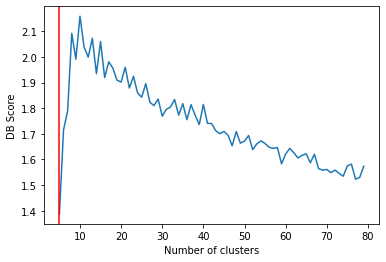

{0, 1, 2, 3, 4}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

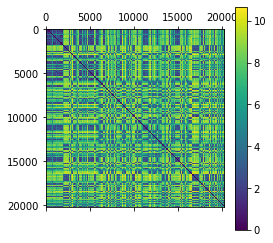

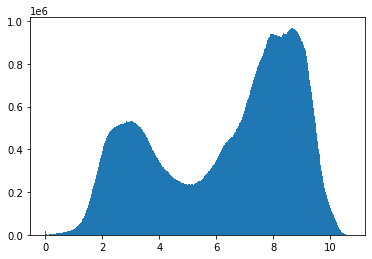

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

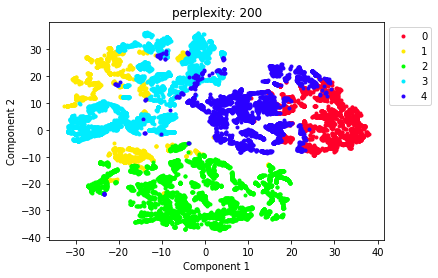

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9214507465628542


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.4149712923843571
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.8653314917127072
layer 4: 0.7417127071823204
layer 5: 0.587189226519337
layer 6: 0.4326657458563536
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.615 | Reg loss: 0.015 | Tree loss: 1.615 | Accuracy: 0.304500 | 0.664 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.598 | Reg loss: 0.015 | Tree loss: 1.598 | Accuracy: 0.309500 | 0.552 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.586 | Reg loss: 0.015 | Tree loss: 1.586 | Accuracy: 0.293000 | 0.521 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.573 | Reg loss: 0.015 | Tree loss: 1.573 | Accuracy: 0.298000 | 0.512 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.563 | Reg loss: 0.015 | Tree loss: 1.563 | Accuracy: 0.294500 | 0.456 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.541 | Reg loss: 0.015 | Tree loss: 1.541 | Accuracy: 0.317000 | 0.44 sec/iter
Epoch: 00 | Batch: 006 / 0

Epoch: 05 | Batch: 000 / 011 | Total loss: 1.525 | Reg loss: 0.014 | Tree loss: 1.525 | Accuracy: 0.410500 | 0.433 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.509 | Reg loss: 0.014 | Tree loss: 1.509 | Accuracy: 0.431000 | 0.433 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.498 | Reg loss: 0.014 | Tree loss: 1.498 | Accuracy: 0.451000 | 0.436 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.482 | Reg loss: 0.014 | Tree loss: 1.482 | Accuracy: 0.457000 | 0.435 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.460 | Reg loss: 0.014 | Tree loss: 1.460 | Accuracy: 0.457500 | 0.435 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.440 | Reg loss: 0.014 | Tree loss: 1.440 | Accuracy: 0.454500 | 0.434 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 1.428 | Reg loss: 0.015 | Tree loss: 1.428 | Accuracy: 0.445000 | 0.431 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 1.426 | Reg loss: 0.015 | Tree loss: 1.426 | Accuracy: 0.459000 | 0.428 sec/iter
Epoch: 0

Epoch: 10 | Batch: 002 / 011 | Total loss: 1.375 | Reg loss: 0.017 | Tree loss: 1.375 | Accuracy: 0.576500 | 0.425 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.345 | Reg loss: 0.017 | Tree loss: 1.345 | Accuracy: 0.603000 | 0.424 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.328 | Reg loss: 0.017 | Tree loss: 1.328 | Accuracy: 0.569500 | 0.426 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.308 | Reg loss: 0.018 | Tree loss: 1.308 | Accuracy: 0.577500 | 0.425 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 1.272 | Reg loss: 0.018 | Tree loss: 1.272 | Accuracy: 0.625000 | 0.425 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 1.279 | Reg loss: 0.018 | Tree loss: 1.279 | Accuracy: 0.590500 | 0.425 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 1.251 | Reg loss: 0.018 | Tree loss: 1.251 | Accuracy: 0.582500 | 0.424 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.252 | Reg loss: 0.019 | Tree loss: 1.252 | Accuracy: 0.570000 | 0.423 sec/iter
Epoch: 1

Epoch: 15 | Batch: 004 / 011 | Total loss: 1.193 | Reg loss: 0.020 | Tree loss: 1.193 | Accuracy: 0.581000 | 0.418 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.176 | Reg loss: 0.021 | Tree loss: 1.176 | Accuracy: 0.582000 | 0.418 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 1.145 | Reg loss: 0.021 | Tree loss: 1.145 | Accuracy: 0.562500 | 0.417 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 1.144 | Reg loss: 0.021 | Tree loss: 1.144 | Accuracy: 0.579500 | 0.417 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 1.127 | Reg loss: 0.021 | Tree loss: 1.127 | Accuracy: 0.589000 | 0.417 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 1.123 | Reg loss: 0.021 | Tree loss: 1.123 | Accuracy: 0.594000 | 0.418 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 1.056 | Reg loss: 0.021 | Tree loss: 1.056 | Accuracy: 0.580205 | 0.418 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 20 | Batch: 006 / 011 | Total loss: 1.061 | Reg loss: 0.023 | Tree loss: 1.061 | Accuracy: 0.591000 | 0.418 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 1.067 | Reg loss: 0.023 | Tree loss: 1.067 | Accuracy: 0.594500 | 0.418 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 1.030 | Reg loss: 0.023 | Tree loss: 1.030 | Accuracy: 0.617000 | 0.419 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 1.032 | Reg loss: 0.023 | Tree loss: 1.032 | Accuracy: 0.607500 | 0.42 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 1.062 | Reg loss: 0.023 | Tree loss: 1.062 | Accuracy: 0.590444 | 0.42 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 1.198 | Reg loss: 0.023 | Tree loss: 1.198 | Accuracy: 0.572500 | 0.421 sec/iter
Epoch: 21 | Batch: 001 

Epoch: 25 | Batch: 008 / 011 | Total loss: 0.959 | Reg loss: 0.025 | Tree loss: 0.959 | Accuracy: 0.646500 | 0.419 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 0.978 | Reg loss: 0.025 | Tree loss: 0.978 | Accuracy: 0.627000 | 0.419 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 0.929 | Reg loss: 0.025 | Tree loss: 0.929 | Accuracy: 0.668942 | 0.419 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 1.092 | Reg loss: 0.024 | Tree loss: 1.092 | Accuracy: 0.577500 | 0.419 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 1.080 | Reg loss: 0.024 | Tree loss: 1.080 | Accuracy: 0.608000 | 0.419 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 1.062 | Reg loss: 0.025 | Tree loss: 1.062 | Accuracy: 0.626000 | 0.419 sec/iter
Epoch: 26 | Batch: 00

Epoch: 30 | Batch: 010 / 011 | Total loss: 0.944 | Reg loss: 0.026 | Tree loss: 0.944 | Accuracy: 0.627986 | 0.417 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 1.045 | Reg loss: 0.026 | Tree loss: 1.045 | Accuracy: 0.583000 | 0.417 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 1.047 | Reg loss: 0.026 | Tree loss: 1.047 | Accuracy: 0.585500 | 0.416 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 1.035 | Reg loss: 0.026 | Tree loss: 1.035 | Accuracy: 0.594500 | 0.416 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 0.993 | Reg loss: 0.026 | Tree loss: 0.993 | Accuracy: 0.617500 | 0.415 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 0.984 | Reg loss: 0.026 | Tree loss: 0.984 | Accuracy: 0.614000 | 0.415 sec/iter
Epoch: 31 | Batch: 00

Epoch: 36 | Batch: 000 / 011 | Total loss: 1.029 | Reg loss: 0.027 | Tree loss: 1.029 | Accuracy: 0.582000 | 0.389 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 1.016 | Reg loss: 0.027 | Tree loss: 1.016 | Accuracy: 0.588000 | 0.389 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 0.976 | Reg loss: 0.027 | Tree loss: 0.976 | Accuracy: 0.614500 | 0.389 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 0.967 | Reg loss: 0.027 | Tree loss: 0.967 | Accuracy: 0.648000 | 0.388 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 0.958 | Reg loss: 0.027 | Tree loss: 0.958 | Accuracy: 0.646000 | 0.388 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 0.918 | Reg loss: 0.027 | Tree loss: 0.918 | Accuracy: 0.658000 | 0.387 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 0.915 | Reg loss: 0.027 | Tree loss: 0.915 | Accuracy: 0.653500 | 0.387 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 0.888 | Reg loss: 0.027 | Tree loss: 0.888 | Accuracy: 0.668500 | 0.386 sec/iter
Epoch: 3

Epoch: 41 | Batch: 002 / 011 | Total loss: 0.941 | Reg loss: 0.027 | Tree loss: 0.941 | Accuracy: 0.636500 | 0.368 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 0.921 | Reg loss: 0.027 | Tree loss: 0.921 | Accuracy: 0.655000 | 0.368 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 0.912 | Reg loss: 0.027 | Tree loss: 0.912 | Accuracy: 0.657000 | 0.367 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 0.882 | Reg loss: 0.027 | Tree loss: 0.882 | Accuracy: 0.673000 | 0.367 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 0.896 | Reg loss: 0.027 | Tree loss: 0.896 | Accuracy: 0.663000 | 0.366 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 0.871 | Reg loss: 0.027 | Tree loss: 0.871 | Accuracy: 0.662000 | 0.366 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 0.890 | Reg loss: 0.027 | Tree loss: 0.890 | Accuracy: 0.647500 | 0.366 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 0.863 | Reg loss: 0.028 | Tree loss: 0.863 | Accuracy: 0.647500 | 0.365 sec/iter
Epoch: 4

Epoch: 46 | Batch: 004 / 011 | Total loss: 0.877 | Reg loss: 0.028 | Tree loss: 0.877 | Accuracy: 0.673000 | 0.351 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 0.889 | Reg loss: 0.028 | Tree loss: 0.889 | Accuracy: 0.665000 | 0.35 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 0.868 | Reg loss: 0.028 | Tree loss: 0.868 | Accuracy: 0.664500 | 0.35 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 0.858 | Reg loss: 0.028 | Tree loss: 0.858 | Accuracy: 0.653500 | 0.35 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 0.872 | Reg loss: 0.028 | Tree loss: 0.872 | Accuracy: 0.647000 | 0.35 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 0.858 | Reg loss: 0.028 | Tree loss: 0.858 | Accuracy: 0.638500 | 0.349 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 0.890 | Reg loss: 0.028 | Tree loss: 0.890 | Accuracy: 0.604096 | 0.349 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.97

Epoch: 51 | Batch: 006 / 011 | Total loss: 0.828 | Reg loss: 0.028 | Tree loss: 0.828 | Accuracy: 0.680000 | 0.338 sec/iter
Epoch: 51 | Batch: 007 / 011 | Total loss: 0.836 | Reg loss: 0.028 | Tree loss: 0.836 | Accuracy: 0.661500 | 0.338 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 0.836 | Reg loss: 0.028 | Tree loss: 0.836 | Accuracy: 0.662500 | 0.337 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 0.800 | Reg loss: 0.029 | Tree loss: 0.800 | Accuracy: 0.670000 | 0.337 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 0.808 | Reg loss: 0.029 | Tree loss: 0.808 | Accuracy: 0.696246 | 0.337 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 0.922 | Reg loss: 0.028 | Tree loss: 0.922 | Accuracy: 0.646500 | 0.337 sec/iter
Epoch: 52 | Batch: 00

Epoch: 56 | Batch: 008 / 011 | Total loss: 0.866 | Reg loss: 0.029 | Tree loss: 0.866 | Accuracy: 0.630000 | 0.328 sec/iter
Epoch: 56 | Batch: 009 / 011 | Total loss: 0.839 | Reg loss: 0.029 | Tree loss: 0.839 | Accuracy: 0.654000 | 0.327 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 0.780 | Reg loss: 0.029 | Tree loss: 0.780 | Accuracy: 0.662116 | 0.327 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 0.931 | Reg loss: 0.029 | Tree loss: 0.931 | Accuracy: 0.640500 | 0.327 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 0.908 | Reg loss: 0.029 | Tree loss: 0.908 | Accuracy: 0.640000 | 0.327 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 0.894 | Reg loss: 0.029 | Tree loss: 0.894 | Accuracy: 0.649500 | 0.327 sec/iter
Epoch: 57 | Batch: 00

Epoch: 61 | Batch: 010 / 011 | Total loss: 0.848 | Reg loss: 0.029 | Tree loss: 0.848 | Accuracy: 0.658703 | 0.319 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 0.916 | Reg loss: 0.029 | Tree loss: 0.916 | Accuracy: 0.644500 | 0.319 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 0.909 | Reg loss: 0.029 | Tree loss: 0.909 | Accuracy: 0.645000 | 0.319 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.874 | Reg loss: 0.029 | Tree loss: 0.874 | Accuracy: 0.665500 | 0.319 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.029 | Tree loss: 0.850 | Accuracy: 0.682500 | 0.318 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.823 | Reg loss: 0.029 | Tree loss: 0.823 | Accuracy: 0.701500 | 0.318 sec/iter
Epoch: 62 | Batch: 00

Epoch: 67 | Batch: 000 / 011 | Total loss: 0.900 | Reg loss: 0.029 | Tree loss: 0.900 | Accuracy: 0.654000 | 0.311 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.922 | Reg loss: 0.029 | Tree loss: 0.922 | Accuracy: 0.637000 | 0.311 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.836 | Reg loss: 0.029 | Tree loss: 0.836 | Accuracy: 0.687000 | 0.311 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.848 | Reg loss: 0.029 | Tree loss: 0.848 | Accuracy: 0.671500 | 0.311 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.816 | Reg loss: 0.029 | Tree loss: 0.816 | Accuracy: 0.691000 | 0.311 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.806 | Reg loss: 0.029 | Tree loss: 0.806 | Accuracy: 0.697000 | 0.311 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.797 | Reg loss: 0.029 | Tree loss: 0.797 | Accuracy: 0.700500 | 0.311 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.798 | Reg loss: 0.030 | Tree loss: 0.798 | Accuracy: 0.663000 | 0.31 sec/iter
Epoch: 67

Epoch: 72 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.030 | Tree loss: 0.859 | Accuracy: 0.666000 | 0.304 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.836 | Reg loss: 0.030 | Tree loss: 0.836 | Accuracy: 0.688000 | 0.304 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.806 | Reg loss: 0.030 | Tree loss: 0.806 | Accuracy: 0.679000 | 0.304 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 0.810 | Reg loss: 0.030 | Tree loss: 0.810 | Accuracy: 0.704500 | 0.304 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 0.804 | Reg loss: 0.030 | Tree loss: 0.804 | Accuracy: 0.696000 | 0.304 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.782 | Reg loss: 0.030 | Tree loss: 0.782 | Accuracy: 0.681500 | 0.304 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 0.815 | Reg loss: 0.030 | Tree loss: 0.815 | Accuracy: 0.655000 | 0.304 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.803 | Reg loss: 0.030 | Tree loss: 0.803 | Accuracy: 0.669000 | 0.303 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 0.808 | Reg loss: 0.030 | Tree loss: 0.808 | Accuracy: 0.692000 | 0.298 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 0.786 | Reg loss: 0.030 | Tree loss: 0.786 | Accuracy: 0.700500 | 0.298 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 0.796 | Reg loss: 0.030 | Tree loss: 0.796 | Accuracy: 0.707000 | 0.298 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 0.772 | Reg loss: 0.030 | Tree loss: 0.772 | Accuracy: 0.691500 | 0.298 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 0.781 | Reg loss: 0.030 | Tree loss: 0.781 | Accuracy: 0.680000 | 0.298 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 0.793 | Reg loss: 0.030 | Tree loss: 0.793 | Accuracy: 0.667500 | 0.298 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 0.789 | Reg loss: 0.030 | Tree loss: 0.789 | Accuracy: 0.692833 | 0.298 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 82 | Batch: 006 / 011 | Total loss: 0.777 | Reg loss: 0.030 | Tree loss: 0.777 | Accuracy: 0.696000 | 0.293 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 0.788 | Reg loss: 0.030 | Tree loss: 0.788 | Accuracy: 0.687500 | 0.293 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 0.808 | Reg loss: 0.030 | Tree loss: 0.808 | Accuracy: 0.673500 | 0.293 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 0.763 | Reg loss: 0.030 | Tree loss: 0.763 | Accuracy: 0.700500 | 0.293 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 0.878 | Reg loss: 0.030 | Tree loss: 0.878 | Accuracy: 0.617747 | 0.293 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 0.843 | Reg loss: 0.030 | Tree loss: 0.843 | Accuracy: 0.666000 | 0.293 sec/iter
Epoch: 83 | Batch: 00

Epoch: 87 | Batch: 008 / 011 | Total loss: 0.795 | Reg loss: 0.030 | Tree loss: 0.795 | Accuracy: 0.678500 | 0.289 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 0.782 | Reg loss: 0.030 | Tree loss: 0.782 | Accuracy: 0.686000 | 0.289 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.787 | Reg loss: 0.030 | Tree loss: 0.787 | Accuracy: 0.726962 | 0.289 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 0.850 | Reg loss: 0.030 | Tree loss: 0.850 | Accuracy: 0.653500 | 0.289 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 0.835 | Reg loss: 0.030 | Tree loss: 0.835 | Accuracy: 0.673500 | 0.289 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 0.819 | Reg loss: 0.030 | Tree loss: 0.819 | Accuracy: 0.676500 | 0.289 sec/iter
Epoch: 88 | Batch: 00

Epoch: 92 | Batch: 010 / 011 | Total loss: 0.797 | Reg loss: 0.031 | Tree loss: 0.797 | Accuracy: 0.675768 | 0.285 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 0.820 | Reg loss: 0.030 | Tree loss: 0.820 | Accuracy: 0.675500 | 0.285 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.827 | Reg loss: 0.030 | Tree loss: 0.827 | Accuracy: 0.682000 | 0.285 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.775 | Reg loss: 0.030 | Tree loss: 0.775 | Accuracy: 0.689500 | 0.285 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.826 | Reg loss: 0.030 | Tree loss: 0.826 | Accuracy: 0.667000 | 0.285 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 0.811 | Reg loss: 0.030 | Tree loss: 0.811 | Accuracy: 0.670000 | 0.285 sec/iter
Epoch: 93 | Batch: 00

Epoch: 98 | Batch: 000 / 011 | Total loss: 0.826 | Reg loss: 0.031 | Tree loss: 0.826 | Accuracy: 0.674500 | 0.282 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 0.838 | Reg loss: 0.031 | Tree loss: 0.838 | Accuracy: 0.664500 | 0.282 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.794 | Reg loss: 0.031 | Tree loss: 0.794 | Accuracy: 0.696500 | 0.282 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.807 | Reg loss: 0.031 | Tree loss: 0.807 | Accuracy: 0.651000 | 0.282 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.806 | Reg loss: 0.031 | Tree loss: 0.806 | Accuracy: 0.695500 | 0.282 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.748 | Reg loss: 0.031 | Tree loss: 0.748 | Accuracy: 0.715000 | 0.282 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.765 | Reg loss: 0.031 | Tree loss: 0.765 | Accuracy: 0.707000 | 0.282 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.786 | Reg loss: 0.031 | Tree loss: 0.786 | Accuracy: 0.704500 | 0.282 sec/iter
Epoch: 9

Epoch: 103 | Batch: 002 / 011 | Total loss: 0.799 | Reg loss: 0.031 | Tree loss: 0.799 | Accuracy: 0.676000 | 0.279 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 0.793 | Reg loss: 0.031 | Tree loss: 0.793 | Accuracy: 0.675500 | 0.279 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 0.770 | Reg loss: 0.031 | Tree loss: 0.770 | Accuracy: 0.695000 | 0.279 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 0.765 | Reg loss: 0.031 | Tree loss: 0.765 | Accuracy: 0.699500 | 0.279 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.764 | Reg loss: 0.031 | Tree loss: 0.764 | Accuracy: 0.699000 | 0.279 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 0.761 | Reg loss: 0.031 | Tree loss: 0.761 | Accuracy: 0.706500 | 0.279 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.789 | Reg loss: 0.031 | Tree loss: 0.789 | Accuracy: 0.694000 | 0.279 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.785 | Reg loss: 0.031 | Tree loss: 0.785 | Accuracy: 0.680000 | 0.279 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 0.784 | Reg loss: 0.031 | Tree loss: 0.784 | Accuracy: 0.685500 | 0.277 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 0.762 | Reg loss: 0.031 | Tree loss: 0.762 | Accuracy: 0.707500 | 0.277 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.764 | Reg loss: 0.031 | Tree loss: 0.764 | Accuracy: 0.694000 | 0.276 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.766 | Reg loss: 0.031 | Tree loss: 0.766 | Accuracy: 0.687500 | 0.276 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.780 | Reg loss: 0.031 | Tree loss: 0.780 | Accuracy: 0.695500 | 0.276 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 0.736 | Reg loss: 0.031 | Tree loss: 0.736 | Accuracy: 0.711500 | 0.276 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.805 | Reg loss: 0.031 | Tree loss: 0.805 | Accuracy: 0.675768 | 0.276 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 113 | Batch: 006 / 011 | Total loss: 0.758 | Reg loss: 0.031 | Tree loss: 0.758 | Accuracy: 0.713000 | 0.274 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.031 | Tree loss: 0.756 | Accuracy: 0.703500 | 0.274 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.737 | Reg loss: 0.031 | Tree loss: 0.737 | Accuracy: 0.711500 | 0.274 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.776 | Reg loss: 0.031 | Tree loss: 0.776 | Accuracy: 0.689500 | 0.274 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.782 | Reg loss: 0.031 | Tree loss: 0.782 | Accuracy: 0.726962 | 0.274 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Batch: 000 / 011 | Total loss: 0.831 | Reg loss: 0.031 | Tree loss: 0.831 | Accuracy: 0.658000 | 0.274 sec/iter
Epoch: 114 | Ba

Epoch: 118 | Batch: 008 / 011 | Total loss: 0.743 | Reg loss: 0.031 | Tree loss: 0.743 | Accuracy: 0.692500 | 0.272 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.731 | Reg loss: 0.031 | Tree loss: 0.731 | Accuracy: 0.721500 | 0.272 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.768 | Reg loss: 0.031 | Tree loss: 0.768 | Accuracy: 0.720137 | 0.272 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 0.814 | Reg loss: 0.031 | Tree loss: 0.814 | Accuracy: 0.658000 | 0.272 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 0.808 | Reg loss: 0.031 | Tree loss: 0.808 | Accuracy: 0.664000 | 0.272 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 0.813 | Reg loss: 0.031 | Tree loss: 0.813 | Accuracy: 0.653500 | 0.272 sec/iter
Epoch: 119 | Ba

Epoch: 123 | Batch: 010 / 011 | Total loss: 0.794 | Reg loss: 0.031 | Tree loss: 0.794 | Accuracy: 0.668942 | 0.27 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.808 | Reg loss: 0.031 | Tree loss: 0.808 | Accuracy: 0.665000 | 0.27 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.031 | Tree loss: 0.787 | Accuracy: 0.673500 | 0.27 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.800 | Reg loss: 0.031 | Tree loss: 0.800 | Accuracy: 0.654000 | 0.27 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.776 | Reg loss: 0.031 | Tree loss: 0.776 | Accuracy: 0.689500 | 0.27 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.031 | Tree loss: 0.767 | Accuracy: 0.703500 | 0.27 sec/iter
Epoch: 124 | Batch: 0

Epoch: 129 | Batch: 000 / 011 | Total loss: 0.808 | Reg loss: 0.031 | Tree loss: 0.808 | Accuracy: 0.663000 | 0.268 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.811 | Reg loss: 0.031 | Tree loss: 0.811 | Accuracy: 0.659000 | 0.268 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.792 | Reg loss: 0.031 | Tree loss: 0.792 | Accuracy: 0.668000 | 0.268 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.776 | Reg loss: 0.031 | Tree loss: 0.776 | Accuracy: 0.681500 | 0.268 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.769 | Reg loss: 0.031 | Tree loss: 0.769 | Accuracy: 0.694000 | 0.268 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.736 | Reg loss: 0.031 | Tree loss: 0.736 | Accuracy: 0.715500 | 0.268 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.722 | Reg loss: 0.031 | Tree loss: 0.722 | Accuracy: 0.723000 | 0.268 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.735 | Reg loss: 0.031 | Tree loss: 0.735 | Accuracy: 0.726000 | 0.268 sec/iter


Epoch: 134 | Batch: 002 / 011 | Total loss: 0.782 | Reg loss: 0.031 | Tree loss: 0.782 | Accuracy: 0.669000 | 0.267 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.781 | Reg loss: 0.032 | Tree loss: 0.781 | Accuracy: 0.681000 | 0.266 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.755 | Reg loss: 0.032 | Tree loss: 0.755 | Accuracy: 0.695500 | 0.266 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.737 | Reg loss: 0.032 | Tree loss: 0.737 | Accuracy: 0.700500 | 0.266 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.743 | Reg loss: 0.032 | Tree loss: 0.743 | Accuracy: 0.712500 | 0.266 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.753 | Reg loss: 0.032 | Tree loss: 0.753 | Accuracy: 0.706500 | 0.266 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.746 | Reg loss: 0.032 | Tree loss: 0.746 | Accuracy: 0.707500 | 0.266 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.737 | Reg loss: 0.032 | Tree loss: 0.737 | Accuracy: 0.712500 | 0.266 sec/iter


Epoch: 139 | Batch: 004 / 011 | Total loss: 0.744 | Reg loss: 0.032 | Tree loss: 0.744 | Accuracy: 0.714000 | 0.265 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.745 | Reg loss: 0.032 | Tree loss: 0.745 | Accuracy: 0.728000 | 0.265 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.732 | Reg loss: 0.032 | Tree loss: 0.732 | Accuracy: 0.727500 | 0.265 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.749 | Reg loss: 0.032 | Tree loss: 0.749 | Accuracy: 0.712000 | 0.265 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.730 | Reg loss: 0.032 | Tree loss: 0.730 | Accuracy: 0.711500 | 0.265 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.728 | Reg loss: 0.032 | Tree loss: 0.728 | Accuracy: 0.714500 | 0.265 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.746 | Reg loss: 0.032 | Tree loss: 0.746 | Accuracy: 0.716724 | 0.265 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 144 | Batch: 006 / 011 | Total loss: 0.744 | Reg loss: 0.032 | Tree loss: 0.744 | Accuracy: 0.701000 | 0.263 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.745 | Reg loss: 0.032 | Tree loss: 0.745 | Accuracy: 0.711500 | 0.263 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.743 | Reg loss: 0.032 | Tree loss: 0.743 | Accuracy: 0.720000 | 0.263 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.747 | Reg loss: 0.032 | Tree loss: 0.747 | Accuracy: 0.715500 | 0.263 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.794 | Reg loss: 0.032 | Tree loss: 0.794 | Accuracy: 0.703072 | 0.263 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 145 | Batch: 000 / 011 | Total loss: 0.791 | Reg loss: 0.032 | Tree loss: 0.791 | Accuracy: 0.665500 | 0.263 sec/iter
Epoch: 145 | Ba

Epoch: 149 | Batch: 008 / 011 | Total loss: 0.743 | Reg loss: 0.032 | Tree loss: 0.743 | Accuracy: 0.718000 | 0.262 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 0.744 | Reg loss: 0.032 | Tree loss: 0.744 | Accuracy: 0.714000 | 0.262 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.740 | Reg loss: 0.032 | Tree loss: 0.740 | Accuracy: 0.733788 | 0.262 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.798 | Reg loss: 0.032 | Tree loss: 0.798 | Accuracy: 0.667500 | 0.262 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.765 | Reg loss: 0.032 | Tree loss: 0.765 | Accuracy: 0.676500 | 0.262 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 0.778 | Reg loss: 0.032 | Tree loss: 0.778 | Accuracy: 0.687000 | 0.261 sec/iter
Epoch: 150 | Ba

Epoch: 154 | Batch: 010 / 011 | Total loss: 0.791 | Reg loss: 0.032 | Tree loss: 0.791 | Accuracy: 0.703072 | 0.26 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.797 | Reg loss: 0.032 | Tree loss: 0.797 | Accuracy: 0.670000 | 0.26 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.816 | Reg loss: 0.032 | Tree loss: 0.816 | Accuracy: 0.656000 | 0.26 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.766 | Reg loss: 0.032 | Tree loss: 0.766 | Accuracy: 0.679000 | 0.26 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.755 | Reg loss: 0.032 | Tree loss: 0.755 | Accuracy: 0.701500 | 0.26 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.032 | Tree loss: 0.767 | Accuracy: 0.688500 | 0.26 sec/iter
Epoch: 155 | Batch: 0

Epoch: 160 | Batch: 000 / 011 | Total loss: 0.798 | Reg loss: 0.032 | Tree loss: 0.798 | Accuracy: 0.670500 | 0.258 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.754 | Reg loss: 0.032 | Tree loss: 0.754 | Accuracy: 0.707000 | 0.258 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.768 | Reg loss: 0.032 | Tree loss: 0.768 | Accuracy: 0.688500 | 0.258 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.756 | Reg loss: 0.032 | Tree loss: 0.756 | Accuracy: 0.693500 | 0.258 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.749 | Reg loss: 0.032 | Tree loss: 0.749 | Accuracy: 0.708000 | 0.258 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.032 | Tree loss: 0.734 | Accuracy: 0.711000 | 0.258 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 0.751 | Reg loss: 0.032 | Tree loss: 0.751 | Accuracy: 0.698500 | 0.258 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 0.724 | Reg loss: 0.032 | Tree loss: 0.724 | Accuracy: 0.717000 | 0.258 sec/iter


Epoch: 165 | Batch: 002 / 011 | Total loss: 0.738 | Reg loss: 0.032 | Tree loss: 0.738 | Accuracy: 0.709500 | 0.257 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.759 | Reg loss: 0.032 | Tree loss: 0.759 | Accuracy: 0.708500 | 0.257 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.727 | Reg loss: 0.032 | Tree loss: 0.727 | Accuracy: 0.719500 | 0.257 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.749 | Reg loss: 0.032 | Tree loss: 0.749 | Accuracy: 0.700000 | 0.257 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.717 | Reg loss: 0.032 | Tree loss: 0.717 | Accuracy: 0.715500 | 0.257 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.737 | Reg loss: 0.032 | Tree loss: 0.737 | Accuracy: 0.711000 | 0.257 sec/iter
Epoch: 165 | Batch: 008 / 011 | Total loss: 0.748 | Reg loss: 0.032 | Tree loss: 0.748 | Accuracy: 0.710000 | 0.257 sec/iter
Epoch: 165 | Batch: 009 / 011 | Total loss: 0.739 | Reg loss: 0.032 | Tree loss: 0.739 | Accuracy: 0.710000 | 0.257 sec/iter


Epoch: 170 | Batch: 004 / 011 | Total loss: 0.752 | Reg loss: 0.032 | Tree loss: 0.752 | Accuracy: 0.690000 | 0.256 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.759 | Reg loss: 0.032 | Tree loss: 0.759 | Accuracy: 0.695500 | 0.256 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.718 | Reg loss: 0.032 | Tree loss: 0.718 | Accuracy: 0.718500 | 0.256 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.735 | Reg loss: 0.032 | Tree loss: 0.735 | Accuracy: 0.701500 | 0.256 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.719 | Reg loss: 0.032 | Tree loss: 0.719 | Accuracy: 0.712500 | 0.256 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 0.749 | Reg loss: 0.032 | Tree loss: 0.749 | Accuracy: 0.720000 | 0.256 sec/iter
Epoch: 170 | Batch: 010 / 011 | Total loss: 0.759 | Reg loss: 0.032 | Tree loss: 0.759 | Accuracy: 0.716724 | 0.256 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 175 | Batch: 006 / 011 | Total loss: 0.717 | Reg loss: 0.032 | Tree loss: 0.717 | Accuracy: 0.715000 | 0.255 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.740 | Reg loss: 0.032 | Tree loss: 0.740 | Accuracy: 0.712500 | 0.255 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 0.750 | Reg loss: 0.032 | Tree loss: 0.750 | Accuracy: 0.705500 | 0.255 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.734 | Reg loss: 0.032 | Tree loss: 0.734 | Accuracy: 0.717500 | 0.255 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.800 | Reg loss: 0.032 | Tree loss: 0.800 | Accuracy: 0.696246 | 0.255 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 176 | Batch: 000 / 011 | Total loss: 0.789 | Reg loss: 0.032 | Tree loss: 0.789 | Accuracy: 0.677000 | 0.255 sec/iter
Epoch: 176 | Ba

Epoch: 180 | Batch: 008 / 011 | Total loss: 0.725 | Reg loss: 0.032 | Tree loss: 0.725 | Accuracy: 0.717000 | 0.254 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 0.707 | Reg loss: 0.032 | Tree loss: 0.707 | Accuracy: 0.725000 | 0.254 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 0.723 | Reg loss: 0.032 | Tree loss: 0.723 | Accuracy: 0.713311 | 0.254 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Batch: 000 / 011 | Total loss: 0.789 | Reg loss: 0.032 | Tree loss: 0.789 | Accuracy: 0.673500 | 0.254 sec/iter
Epoch: 181 | Batch: 001 / 011 | Total loss: 0.767 | Reg loss: 0.032 | Tree loss: 0.767 | Accuracy: 0.685000 | 0.254 sec/iter
Epoch: 181 | Batch: 002 / 011 | Total loss: 0.740 | Reg loss: 0.032 | Tree loss: 0.740 | Accuracy: 0.694000 | 0.254 sec/iter
Epoch: 181 | Ba

Epoch: 185 | Batch: 010 / 011 | Total loss: 0.787 | Reg loss: 0.032 | Tree loss: 0.787 | Accuracy: 0.692833 | 0.253 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 186 | Batch: 000 / 011 | Total loss: 0.775 | Reg loss: 0.032 | Tree loss: 0.775 | Accuracy: 0.683000 | 0.253 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 0.779 | Reg loss: 0.032 | Tree loss: 0.779 | Accuracy: 0.666000 | 0.253 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 0.772 | Reg loss: 0.032 | Tree loss: 0.772 | Accuracy: 0.688500 | 0.253 sec/iter
Epoch: 186 | Batch: 003 / 011 | Total loss: 0.741 | Reg loss: 0.032 | Tree loss: 0.741 | Accuracy: 0.688500 | 0.253 sec/iter
Epoch: 186 | Batch: 004 / 011 | Total loss: 0.762 | Reg loss: 0.032 | Tree loss: 0.762 | Accuracy: 0.689000 | 0.253 sec/iter
Epoch: 186 | Ba

Epoch: 191 | Batch: 000 / 011 | Total loss: 0.771 | Reg loss: 0.032 | Tree loss: 0.771 | Accuracy: 0.684000 | 0.252 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 0.767 | Reg loss: 0.032 | Tree loss: 0.767 | Accuracy: 0.689000 | 0.252 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 0.758 | Reg loss: 0.032 | Tree loss: 0.758 | Accuracy: 0.680000 | 0.252 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 0.759 | Reg loss: 0.032 | Tree loss: 0.759 | Accuracy: 0.684500 | 0.252 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 0.759 | Reg loss: 0.032 | Tree loss: 0.759 | Accuracy: 0.698000 | 0.252 sec/iter
Epoch: 191 | Batch: 005 / 011 | Total loss: 0.713 | Reg loss: 0.032 | Tree loss: 0.713 | Accuracy: 0.712000 | 0.252 sec/iter
Epoch: 191 | Batch: 006 / 011 | Total loss: 0.743 | Reg loss: 0.032 | Tree loss: 0.743 | Accuracy: 0.702500 | 0.252 sec/iter
Epoch: 191 | Batch: 007 / 011 | Total loss: 0.712 | Reg loss: 0.032 | Tree loss: 0.712 | Accuracy: 0.722500 | 0.252 sec/iter


Epoch: 196 | Batch: 002 / 011 | Total loss: 0.769 | Reg loss: 0.032 | Tree loss: 0.769 | Accuracy: 0.673000 | 0.251 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.727 | Reg loss: 0.032 | Tree loss: 0.727 | Accuracy: 0.703500 | 0.251 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.728 | Reg loss: 0.032 | Tree loss: 0.728 | Accuracy: 0.711000 | 0.251 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.736 | Reg loss: 0.032 | Tree loss: 0.736 | Accuracy: 0.707000 | 0.251 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.704 | Reg loss: 0.032 | Tree loss: 0.704 | Accuracy: 0.720000 | 0.251 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 0.739 | Reg loss: 0.032 | Tree loss: 0.739 | Accuracy: 0.708000 | 0.251 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 0.739 | Reg loss: 0.032 | Tree loss: 0.739 | Accuracy: 0.698000 | 0.251 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 0.748 | Reg loss: 0.032 | Tree loss: 0.748 | Accuracy: 0.714000 | 0.251 sec/iter


Epoch: 201 | Batch: 004 / 011 | Total loss: 0.734 | Reg loss: 0.032 | Tree loss: 0.734 | Accuracy: 0.701500 | 0.251 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.751 | Reg loss: 0.032 | Tree loss: 0.751 | Accuracy: 0.699500 | 0.251 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.725 | Reg loss: 0.032 | Tree loss: 0.725 | Accuracy: 0.707000 | 0.25 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.717 | Reg loss: 0.032 | Tree loss: 0.717 | Accuracy: 0.720500 | 0.25 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.728 | Reg loss: 0.032 | Tree loss: 0.728 | Accuracy: 0.707500 | 0.25 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.717 | Reg loss: 0.032 | Tree loss: 0.717 | Accuracy: 0.720000 | 0.25 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.712 | Reg loss: 0.032 | Tree loss: 0.712 | Accuracy: 0.723549 | 0.25 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3

Epoch: 206 | Batch: 006 / 011 | Total loss: 0.720 | Reg loss: 0.032 | Tree loss: 0.720 | Accuracy: 0.710000 | 0.25 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.729 | Reg loss: 0.032 | Tree loss: 0.729 | Accuracy: 0.715500 | 0.25 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.713 | Reg loss: 0.032 | Tree loss: 0.713 | Accuracy: 0.713500 | 0.25 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.729 | Reg loss: 0.032 | Tree loss: 0.729 | Accuracy: 0.717500 | 0.25 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.711 | Reg loss: 0.032 | Tree loss: 0.711 | Accuracy: 0.740614 | 0.25 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 207 | Batch: 000 / 011 | Total loss: 0.757 | Reg loss: 0.032 | Tree loss: 0.757 | Accuracy: 0.693500 | 0.25 sec/iter
Epoch: 207 | Batch: 0

Epoch: 211 | Batch: 008 / 011 | Total loss: 0.722 | Reg loss: 0.032 | Tree loss: 0.722 | Accuracy: 0.717500 | 0.249 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.720 | Reg loss: 0.032 | Tree loss: 0.720 | Accuracy: 0.712500 | 0.249 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.696 | Reg loss: 0.032 | Tree loss: 0.696 | Accuracy: 0.744027 | 0.249 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 212 | Batch: 000 / 011 | Total loss: 0.770 | Reg loss: 0.032 | Tree loss: 0.770 | Accuracy: 0.684000 | 0.249 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 0.780 | Reg loss: 0.032 | Tree loss: 0.780 | Accuracy: 0.660000 | 0.249 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 0.783 | Reg loss: 0.032 | Tree loss: 0.783 | Accuracy: 0.655000 | 0.249 sec/iter
Epoch: 212 | Ba

Epoch: 216 | Batch: 010 / 011 | Total loss: 0.780 | Reg loss: 0.032 | Tree loss: 0.780 | Accuracy: 0.709898 | 0.248 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 217 | Batch: 000 / 011 | Total loss: 0.776 | Reg loss: 0.032 | Tree loss: 0.776 | Accuracy: 0.690000 | 0.248 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 0.788 | Reg loss: 0.032 | Tree loss: 0.788 | Accuracy: 0.670500 | 0.248 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 0.741 | Reg loss: 0.032 | Tree loss: 0.741 | Accuracy: 0.701500 | 0.248 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 0.767 | Reg loss: 0.032 | Tree loss: 0.767 | Accuracy: 0.672000 | 0.248 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 0.705 | Reg loss: 0.032 | Tree loss: 0.705 | Accuracy: 0.720000 | 0.248 sec/iter
Epoch: 217 | Ba

Epoch: 222 | Batch: 000 / 011 | Total loss: 0.760 | Reg loss: 0.032 | Tree loss: 0.760 | Accuracy: 0.689000 | 0.247 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 0.788 | Reg loss: 0.032 | Tree loss: 0.788 | Accuracy: 0.675000 | 0.247 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 0.745 | Reg loss: 0.032 | Tree loss: 0.745 | Accuracy: 0.691000 | 0.247 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 0.740 | Reg loss: 0.032 | Tree loss: 0.740 | Accuracy: 0.696000 | 0.247 sec/iter
Epoch: 222 | Batch: 004 / 011 | Total loss: 0.744 | Reg loss: 0.032 | Tree loss: 0.744 | Accuracy: 0.697500 | 0.247 sec/iter
Epoch: 222 | Batch: 005 / 011 | Total loss: 0.732 | Reg loss: 0.032 | Tree loss: 0.732 | Accuracy: 0.702000 | 0.247 sec/iter
Epoch: 222 | Batch: 006 / 011 | Total loss: 0.718 | Reg loss: 0.032 | Tree loss: 0.718 | Accuracy: 0.727500 | 0.247 sec/iter
Epoch: 222 | Batch: 007 / 011 | Total loss: 0.690 | Reg loss: 0.032 | Tree loss: 0.690 | Accuracy: 0.717000 | 0.247 sec/iter


Epoch: 227 | Batch: 002 / 011 | Total loss: 0.763 | Reg loss: 0.031 | Tree loss: 0.763 | Accuracy: 0.679000 | 0.247 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 0.740 | Reg loss: 0.032 | Tree loss: 0.740 | Accuracy: 0.699500 | 0.247 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 0.733 | Reg loss: 0.032 | Tree loss: 0.733 | Accuracy: 0.699500 | 0.247 sec/iter
Epoch: 227 | Batch: 005 / 011 | Total loss: 0.730 | Reg loss: 0.032 | Tree loss: 0.730 | Accuracy: 0.694000 | 0.247 sec/iter
Epoch: 227 | Batch: 006 / 011 | Total loss: 0.733 | Reg loss: 0.032 | Tree loss: 0.733 | Accuracy: 0.706000 | 0.247 sec/iter
Epoch: 227 | Batch: 007 / 011 | Total loss: 0.754 | Reg loss: 0.032 | Tree loss: 0.754 | Accuracy: 0.706500 | 0.247 sec/iter
Epoch: 227 | Batch: 008 / 011 | Total loss: 0.720 | Reg loss: 0.032 | Tree loss: 0.720 | Accuracy: 0.727000 | 0.247 sec/iter
Epoch: 227 | Batch: 009 / 011 | Total loss: 0.723 | Reg loss: 0.032 | Tree loss: 0.723 | Accuracy: 0.716500 | 0.247 sec/iter


Epoch: 232 | Batch: 004 / 011 | Total loss: 0.749 | Reg loss: 0.031 | Tree loss: 0.749 | Accuracy: 0.691000 | 0.246 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 0.725 | Reg loss: 0.031 | Tree loss: 0.725 | Accuracy: 0.702500 | 0.246 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 0.724 | Reg loss: 0.031 | Tree loss: 0.724 | Accuracy: 0.717500 | 0.246 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.731500 | 0.246 sec/iter
Epoch: 232 | Batch: 008 / 011 | Total loss: 0.704 | Reg loss: 0.031 | Tree loss: 0.704 | Accuracy: 0.729500 | 0.246 sec/iter
Epoch: 232 | Batch: 009 / 011 | Total loss: 0.764 | Reg loss: 0.031 | Tree loss: 0.764 | Accuracy: 0.692500 | 0.246 sec/iter
Epoch: 232 | Batch: 010 / 011 | Total loss: 0.749 | Reg loss: 0.032 | Tree loss: 0.749 | Accuracy: 0.699659 | 0.246 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 237 | Batch: 006 / 011 | Total loss: 0.740 | Reg loss: 0.031 | Tree loss: 0.740 | Accuracy: 0.698500 | 0.245 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 0.728 | Reg loss: 0.031 | Tree loss: 0.728 | Accuracy: 0.715500 | 0.245 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 0.727 | Reg loss: 0.031 | Tree loss: 0.727 | Accuracy: 0.713500 | 0.245 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 0.705 | Reg loss: 0.031 | Tree loss: 0.705 | Accuracy: 0.737500 | 0.245 sec/iter
Epoch: 237 | Batch: 010 / 011 | Total loss: 0.789 | Reg loss: 0.031 | Tree loss: 0.789 | Accuracy: 0.686007 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 238 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.031 | Tree loss: 0.779 | Accuracy: 0.684000 | 0.245 sec/iter
Epoch: 238 | Ba

Epoch: 242 | Batch: 008 / 011 | Total loss: 0.712 | Reg loss: 0.031 | Tree loss: 0.712 | Accuracy: 0.723500 | 0.245 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 0.720 | Reg loss: 0.031 | Tree loss: 0.720 | Accuracy: 0.715000 | 0.245 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 0.734 | Reg loss: 0.031 | Tree loss: 0.734 | Accuracy: 0.720137 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 243 | Batch: 000 / 011 | Total loss: 0.764 | Reg loss: 0.031 | Tree loss: 0.764 | Accuracy: 0.697000 | 0.245 sec/iter
Epoch: 243 | Batch: 001 / 011 | Total loss: 0.771 | Reg loss: 0.031 | Tree loss: 0.771 | Accuracy: 0.670500 | 0.245 sec/iter
Epoch: 243 | Batch: 002 / 011 | Total loss: 0.757 | Reg loss: 0.031 | Tree loss: 0.757 | Accuracy: 0.673500 | 0.245 sec/iter
Epoch: 243 | Ba

Epoch: 247 | Batch: 010 / 011 | Total loss: 0.744 | Reg loss: 0.031 | Tree loss: 0.744 | Accuracy: 0.737201 | 0.244 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 248 | Batch: 000 / 011 | Total loss: 0.780 | Reg loss: 0.031 | Tree loss: 0.780 | Accuracy: 0.682000 | 0.244 sec/iter
Epoch: 248 | Batch: 001 / 011 | Total loss: 0.754 | Reg loss: 0.031 | Tree loss: 0.754 | Accuracy: 0.692000 | 0.244 sec/iter
Epoch: 248 | Batch: 002 / 011 | Total loss: 0.750 | Reg loss: 0.031 | Tree loss: 0.750 | Accuracy: 0.697000 | 0.244 sec/iter
Epoch: 248 | Batch: 003 / 011 | Total loss: 0.753 | Reg loss: 0.031 | Tree loss: 0.753 | Accuracy: 0.685000 | 0.244 sec/iter
Epoch: 248 | Batch: 004 / 011 | Total loss: 0.737 | Reg loss: 0.031 | Tree loss: 0.737 | Accuracy: 0.695500 | 0.244 sec/iter
Epoch: 248 | Ba

Epoch: 253 | Batch: 000 / 011 | Total loss: 0.766 | Reg loss: 0.031 | Tree loss: 0.766 | Accuracy: 0.681500 | 0.244 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 0.759 | Reg loss: 0.031 | Tree loss: 0.759 | Accuracy: 0.694000 | 0.244 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 0.759 | Reg loss: 0.031 | Tree loss: 0.759 | Accuracy: 0.685500 | 0.244 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 0.728 | Reg loss: 0.031 | Tree loss: 0.728 | Accuracy: 0.695000 | 0.244 sec/iter
Epoch: 253 | Batch: 004 / 011 | Total loss: 0.744 | Reg loss: 0.031 | Tree loss: 0.744 | Accuracy: 0.696000 | 0.243 sec/iter
Epoch: 253 | Batch: 005 / 011 | Total loss: 0.727 | Reg loss: 0.031 | Tree loss: 0.727 | Accuracy: 0.693000 | 0.243 sec/iter
Epoch: 253 | Batch: 006 / 011 | Total loss: 0.726 | Reg loss: 0.031 | Tree loss: 0.726 | Accuracy: 0.701500 | 0.243 sec/iter
Epoch: 253 | Batch: 007 / 011 | Total loss: 0.738 | Reg loss: 0.031 | Tree loss: 0.738 | Accuracy: 0.714000 | 0.243 sec/iter


Epoch: 258 | Batch: 002 / 011 | Total loss: 0.767 | Reg loss: 0.031 | Tree loss: 0.767 | Accuracy: 0.679000 | 0.243 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.708000 | 0.243 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 0.728 | Reg loss: 0.031 | Tree loss: 0.728 | Accuracy: 0.695500 | 0.243 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 0.715 | Reg loss: 0.031 | Tree loss: 0.715 | Accuracy: 0.709500 | 0.243 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.713000 | 0.243 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.719000 | 0.243 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.710500 | 0.243 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 0.715 | Reg loss: 0.031 | Tree loss: 0.715 | Accuracy: 0.717500 | 0.243 sec/iter


Epoch: 263 | Batch: 005 / 011 | Total loss: 0.742 | Reg loss: 0.031 | Tree loss: 0.742 | Accuracy: 0.705000 | 0.243 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 0.723 | Reg loss: 0.031 | Tree loss: 0.723 | Accuracy: 0.715000 | 0.243 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.722 | Reg loss: 0.031 | Tree loss: 0.722 | Accuracy: 0.705000 | 0.243 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 0.723 | Reg loss: 0.031 | Tree loss: 0.723 | Accuracy: 0.718500 | 0.243 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.721000 | 0.242 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 0.765 | Reg loss: 0.031 | Tree loss: 0.765 | Accuracy: 0.686007 | 0.242 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 264 | Ba

Epoch: 268 | Batch: 008 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.717500 | 0.242 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 0.754 | Reg loss: 0.031 | Tree loss: 0.754 | Accuracy: 0.694500 | 0.242 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 0.711 | Reg loss: 0.031 | Tree loss: 0.711 | Accuracy: 0.730375 | 0.242 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.749 | Reg loss: 0.031 | Tree loss: 0.749 | Accuracy: 0.691500 | 0.242 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.763 | Reg loss: 0.031 | Tree loss: 0.763 | Accuracy: 0.665000 | 0.242 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 0.744 | Reg loss: 0.031 | Tree loss: 0.744 | Accuracy: 0.702000 | 0.242 sec/iter
Epoch: 269 | Ba

Epoch: 273 | Batch: 010 / 011 | Total loss: 0.749 | Reg loss: 0.031 | Tree loss: 0.749 | Accuracy: 0.706485 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 274 | Batch: 000 / 011 | Total loss: 0.749 | Reg loss: 0.031 | Tree loss: 0.749 | Accuracy: 0.685000 | 0.241 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 0.776 | Reg loss: 0.031 | Tree loss: 0.776 | Accuracy: 0.683500 | 0.241 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 0.761 | Reg loss: 0.031 | Tree loss: 0.761 | Accuracy: 0.689500 | 0.241 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 0.740 | Reg loss: 0.031 | Tree loss: 0.740 | Accuracy: 0.685500 | 0.241 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 0.745 | Reg loss: 0.031 | Tree loss: 0.745 | Accuracy: 0.675500 | 0.241 sec/iter
Epoch: 274 | Ba

Epoch: 279 | Batch: 000 / 011 | Total loss: 0.775 | Reg loss: 0.031 | Tree loss: 0.775 | Accuracy: 0.677000 | 0.241 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 0.750 | Reg loss: 0.031 | Tree loss: 0.750 | Accuracy: 0.692500 | 0.241 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 0.750 | Reg loss: 0.031 | Tree loss: 0.750 | Accuracy: 0.697000 | 0.241 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.724 | Reg loss: 0.031 | Tree loss: 0.724 | Accuracy: 0.711500 | 0.241 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.743 | Reg loss: 0.031 | Tree loss: 0.743 | Accuracy: 0.714000 | 0.241 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 0.729 | Reg loss: 0.031 | Tree loss: 0.729 | Accuracy: 0.710000 | 0.241 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 0.726 | Reg loss: 0.031 | Tree loss: 0.726 | Accuracy: 0.704500 | 0.241 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 0.738 | Reg loss: 0.031 | Tree loss: 0.738 | Accuracy: 0.721000 | 0.241 sec/iter


Epoch: 284 | Batch: 002 / 011 | Total loss: 0.762 | Reg loss: 0.031 | Tree loss: 0.762 | Accuracy: 0.681500 | 0.241 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 0.758 | Reg loss: 0.031 | Tree loss: 0.758 | Accuracy: 0.684000 | 0.241 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 0.720 | Reg loss: 0.031 | Tree loss: 0.720 | Accuracy: 0.707500 | 0.241 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.705 | Reg loss: 0.031 | Tree loss: 0.705 | Accuracy: 0.718000 | 0.241 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.731 | Reg loss: 0.031 | Tree loss: 0.731 | Accuracy: 0.707000 | 0.241 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.751 | Reg loss: 0.031 | Tree loss: 0.751 | Accuracy: 0.690000 | 0.241 sec/iter
Epoch: 284 | Batch: 008 / 011 | Total loss: 0.678 | Reg loss: 0.031 | Tree loss: 0.678 | Accuracy: 0.742500 | 0.241 sec/iter
Epoch: 284 | Batch: 009 / 011 | Total loss: 0.719 | Reg loss: 0.031 | Tree loss: 0.719 | Accuracy: 0.734500 | 0.24 sec/iter
E

Epoch: 289 | Batch: 004 / 011 | Total loss: 0.731 | Reg loss: 0.031 | Tree loss: 0.731 | Accuracy: 0.703500 | 0.24 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.703000 | 0.24 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 0.711 | Reg loss: 0.031 | Tree loss: 0.711 | Accuracy: 0.706500 | 0.24 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.708500 | 0.24 sec/iter
Epoch: 289 | Batch: 008 / 011 | Total loss: 0.734 | Reg loss: 0.031 | Tree loss: 0.734 | Accuracy: 0.708500 | 0.24 sec/iter
Epoch: 289 | Batch: 009 / 011 | Total loss: 0.717 | Reg loss: 0.031 | Tree loss: 0.717 | Accuracy: 0.725500 | 0.24 sec/iter
Epoch: 289 | Batch: 010 / 011 | Total loss: 0.662 | Reg loss: 0.031 | Tree loss: 0.662 | Accuracy: 0.788396 | 0.24 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 294 | Batch: 006 / 011 | Total loss: 0.719 | Reg loss: 0.031 | Tree loss: 0.719 | Accuracy: 0.697500 | 0.241 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.732 | Reg loss: 0.031 | Tree loss: 0.732 | Accuracy: 0.714000 | 0.241 sec/iter
Epoch: 294 | Batch: 008 / 011 | Total loss: 0.716 | Reg loss: 0.031 | Tree loss: 0.716 | Accuracy: 0.728500 | 0.241 sec/iter
Epoch: 294 | Batch: 009 / 011 | Total loss: 0.713 | Reg loss: 0.031 | Tree loss: 0.713 | Accuracy: 0.727000 | 0.241 sec/iter
Epoch: 294 | Batch: 010 / 011 | Total loss: 0.675 | Reg loss: 0.031 | Tree loss: 0.675 | Accuracy: 0.730375 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 295 | Batch: 000 / 011 | Total loss: 0.778 | Reg loss: 0.031 | Tree loss: 0.778 | Accuracy: 0.683000 | 0.241 sec/iter
Epoch: 295 | Ba

Epoch: 299 | Batch: 008 / 011 | Total loss: 0.736 | Reg loss: 0.031 | Tree loss: 0.736 | Accuracy: 0.710500 | 0.241 sec/iter
Epoch: 299 | Batch: 009 / 011 | Total loss: 0.722 | Reg loss: 0.031 | Tree loss: 0.722 | Accuracy: 0.727000 | 0.241 sec/iter
Epoch: 299 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.031 | Tree loss: 0.784 | Accuracy: 0.706485 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 300 | Batch: 000 / 011 | Total loss: 0.748 | Reg loss: 0.031 | Tree loss: 0.748 | Accuracy: 0.707500 | 0.241 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 0.749 | Reg loss: 0.031 | Tree loss: 0.749 | Accuracy: 0.689500 | 0.241 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 0.753 | Reg loss: 0.031 | Tree loss: 0.753 | Accuracy: 0.685000 | 0.241 sec/iter
Epoch: 300 | Ba

Epoch: 304 | Batch: 010 / 011 | Total loss: 0.698 | Reg loss: 0.031 | Tree loss: 0.698 | Accuracy: 0.713311 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 305 | Batch: 000 / 011 | Total loss: 0.788 | Reg loss: 0.031 | Tree loss: 0.788 | Accuracy: 0.666000 | 0.241 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 0.756 | Reg loss: 0.031 | Tree loss: 0.756 | Accuracy: 0.683000 | 0.241 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.769 | Reg loss: 0.031 | Tree loss: 0.769 | Accuracy: 0.675500 | 0.241 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 0.755 | Reg loss: 0.031 | Tree loss: 0.755 | Accuracy: 0.683500 | 0.241 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.701500 | 0.241 sec/iter
Epoch: 305 | Ba

Epoch: 310 | Batch: 000 / 011 | Total loss: 0.766 | Reg loss: 0.031 | Tree loss: 0.766 | Accuracy: 0.696500 | 0.241 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 0.754 | Reg loss: 0.031 | Tree loss: 0.754 | Accuracy: 0.682500 | 0.241 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 0.747 | Reg loss: 0.031 | Tree loss: 0.747 | Accuracy: 0.692000 | 0.241 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 0.742 | Reg loss: 0.031 | Tree loss: 0.742 | Accuracy: 0.706500 | 0.241 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 0.742 | Reg loss: 0.031 | Tree loss: 0.742 | Accuracy: 0.697000 | 0.241 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 0.700 | Reg loss: 0.031 | Tree loss: 0.700 | Accuracy: 0.707500 | 0.241 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 0.710 | Reg loss: 0.031 | Tree loss: 0.710 | Accuracy: 0.723500 | 0.241 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 0.726 | Reg loss: 0.031 | Tree loss: 0.726 | Accuracy: 0.723000 | 0.241 sec/iter


Epoch: 315 | Batch: 002 / 011 | Total loss: 0.743 | Reg loss: 0.031 | Tree loss: 0.743 | Accuracy: 0.687000 | 0.241 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 0.731 | Reg loss: 0.031 | Tree loss: 0.731 | Accuracy: 0.696000 | 0.241 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 0.726 | Reg loss: 0.031 | Tree loss: 0.726 | Accuracy: 0.707000 | 0.241 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.699500 | 0.241 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 0.736 | Reg loss: 0.031 | Tree loss: 0.736 | Accuracy: 0.708500 | 0.241 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 0.731 | Reg loss: 0.031 | Tree loss: 0.731 | Accuracy: 0.713000 | 0.241 sec/iter
Epoch: 315 | Batch: 008 / 011 | Total loss: 0.719 | Reg loss: 0.031 | Tree loss: 0.719 | Accuracy: 0.726000 | 0.241 sec/iter
Epoch: 315 | Batch: 009 / 011 | Total loss: 0.735 | Reg loss: 0.031 | Tree loss: 0.735 | Accuracy: 0.708000 | 0.241 sec/iter


Epoch: 320 | Batch: 004 / 011 | Total loss: 0.734 | Reg loss: 0.031 | Tree loss: 0.734 | Accuracy: 0.695000 | 0.241 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 0.722 | Reg loss: 0.031 | Tree loss: 0.722 | Accuracy: 0.712500 | 0.241 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 0.735 | Reg loss: 0.031 | Tree loss: 0.735 | Accuracy: 0.698500 | 0.241 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.725000 | 0.241 sec/iter
Epoch: 320 | Batch: 008 / 011 | Total loss: 0.734 | Reg loss: 0.031 | Tree loss: 0.734 | Accuracy: 0.723500 | 0.241 sec/iter
Epoch: 320 | Batch: 009 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.733500 | 0.241 sec/iter
Epoch: 320 | Batch: 010 / 011 | Total loss: 0.652 | Reg loss: 0.031 | Tree loss: 0.652 | Accuracy: 0.750853 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 325 | Batch: 006 / 011 | Total loss: 0.706 | Reg loss: 0.031 | Tree loss: 0.706 | Accuracy: 0.716000 | 0.241 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.724 | Reg loss: 0.031 | Tree loss: 0.724 | Accuracy: 0.717500 | 0.241 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.723000 | 0.241 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 0.717 | Reg loss: 0.031 | Tree loss: 0.717 | Accuracy: 0.726500 | 0.241 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.672 | Reg loss: 0.031 | Tree loss: 0.672 | Accuracy: 0.730375 | 0.241 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 326 | Batch: 000 / 011 | Total loss: 0.755 | Reg loss: 0.031 | Tree loss: 0.755 | Accuracy: 0.684500 | 0.242 sec/iter
Epoch: 326 | Ba

Epoch: 330 | Batch: 008 / 011 | Total loss: 0.715 | Reg loss: 0.031 | Tree loss: 0.715 | Accuracy: 0.715000 | 0.242 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 0.713 | Reg loss: 0.031 | Tree loss: 0.713 | Accuracy: 0.732000 | 0.242 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 0.677 | Reg loss: 0.031 | Tree loss: 0.677 | Accuracy: 0.747440 | 0.242 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 331 | Batch: 000 / 011 | Total loss: 0.753 | Reg loss: 0.031 | Tree loss: 0.753 | Accuracy: 0.696000 | 0.242 sec/iter
Epoch: 331 | Batch: 001 / 011 | Total loss: 0.760 | Reg loss: 0.031 | Tree loss: 0.760 | Accuracy: 0.694000 | 0.242 sec/iter
Epoch: 331 | Batch: 002 / 011 | Total loss: 0.761 | Reg loss: 0.031 | Tree loss: 0.761 | Accuracy: 0.685000 | 0.242 sec/iter
Epoch: 331 | Ba

Epoch: 335 | Batch: 010 / 011 | Total loss: 0.762 | Reg loss: 0.031 | Tree loss: 0.762 | Accuracy: 0.709898 | 0.242 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 336 | Batch: 000 / 011 | Total loss: 0.772 | Reg loss: 0.031 | Tree loss: 0.772 | Accuracy: 0.684500 | 0.242 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 0.727 | Reg loss: 0.031 | Tree loss: 0.727 | Accuracy: 0.701000 | 0.242 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 0.745 | Reg loss: 0.031 | Tree loss: 0.745 | Accuracy: 0.687000 | 0.242 sec/iter
Epoch: 336 | Batch: 003 / 011 | Total loss: 0.744 | Reg loss: 0.031 | Tree loss: 0.744 | Accuracy: 0.694500 | 0.242 sec/iter
Epoch: 336 | Batch: 004 / 011 | Total loss: 0.739 | Reg loss: 0.031 | Tree loss: 0.739 | Accuracy: 0.703000 | 0.242 sec/iter
Epoch: 336 | Ba

layer 6: 0.9723756906077349
Epoch: 341 | Batch: 000 / 011 | Total loss: 0.773 | Reg loss: 0.031 | Tree loss: 0.773 | Accuracy: 0.682500 | 0.242 sec/iter
Epoch: 341 | Batch: 001 / 011 | Total loss: 0.761 | Reg loss: 0.031 | Tree loss: 0.761 | Accuracy: 0.684500 | 0.242 sec/iter
Epoch: 341 | Batch: 002 / 011 | Total loss: 0.745 | Reg loss: 0.031 | Tree loss: 0.745 | Accuracy: 0.695500 | 0.242 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.707000 | 0.242 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 0.727 | Reg loss: 0.031 | Tree loss: 0.727 | Accuracy: 0.700500 | 0.242 sec/iter
Epoch: 341 | Batch: 005 / 011 | Total loss: 0.723 | Reg loss: 0.031 | Tree loss: 0.723 | Accuracy: 0.710500 | 0.242 sec/iter
Epoch: 341 | Batch: 006 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.721000 | 0.242 sec/iter
Epoch: 341 | Batch: 007 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy

Epoch: 346 | Batch: 001 / 011 | Total loss: 0.746 | Reg loss: 0.031 | Tree loss: 0.746 | Accuracy: 0.690000 | 0.243 sec/iter
Epoch: 346 | Batch: 002 / 011 | Total loss: 0.759 | Reg loss: 0.031 | Tree loss: 0.759 | Accuracy: 0.674000 | 0.243 sec/iter
Epoch: 346 | Batch: 003 / 011 | Total loss: 0.744 | Reg loss: 0.031 | Tree loss: 0.744 | Accuracy: 0.689000 | 0.243 sec/iter
Epoch: 346 | Batch: 004 / 011 | Total loss: 0.741 | Reg loss: 0.031 | Tree loss: 0.741 | Accuracy: 0.700500 | 0.243 sec/iter
Epoch: 346 | Batch: 005 / 011 | Total loss: 0.749 | Reg loss: 0.031 | Tree loss: 0.749 | Accuracy: 0.696000 | 0.243 sec/iter
Epoch: 346 | Batch: 006 / 011 | Total loss: 0.725 | Reg loss: 0.031 | Tree loss: 0.725 | Accuracy: 0.705000 | 0.243 sec/iter
Epoch: 346 | Batch: 007 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.709500 | 0.243 sec/iter
Epoch: 346 | Batch: 008 / 011 | Total loss: 0.717 | Reg loss: 0.031 | Tree loss: 0.717 | Accuracy: 0.729000 | 0.243 sec/iter


Epoch: 351 | Batch: 003 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.702500 | 0.243 sec/iter
Epoch: 351 | Batch: 004 / 011 | Total loss: 0.754 | Reg loss: 0.031 | Tree loss: 0.754 | Accuracy: 0.684000 | 0.243 sec/iter
Epoch: 351 | Batch: 005 / 011 | Total loss: 0.713 | Reg loss: 0.031 | Tree loss: 0.713 | Accuracy: 0.711500 | 0.243 sec/iter
Epoch: 351 | Batch: 006 / 011 | Total loss: 0.727 | Reg loss: 0.031 | Tree loss: 0.727 | Accuracy: 0.718000 | 0.243 sec/iter
Epoch: 351 | Batch: 007 / 011 | Total loss: 0.696 | Reg loss: 0.031 | Tree loss: 0.696 | Accuracy: 0.719000 | 0.243 sec/iter
Epoch: 351 | Batch: 008 / 011 | Total loss: 0.693 | Reg loss: 0.031 | Tree loss: 0.693 | Accuracy: 0.743500 | 0.243 sec/iter
Epoch: 351 | Batch: 009 / 011 | Total loss: 0.748 | Reg loss: 0.031 | Tree loss: 0.748 | Accuracy: 0.707000 | 0.243 sec/iter
Epoch: 351 | Batch: 010 / 011 | Total loss: 0.756 | Reg loss: 0.031 | Tree loss: 0.756 | Accuracy: 0.730375 | 0.243 sec/iter


Epoch: 356 | Batch: 005 / 011 | Total loss: 0.698 | Reg loss: 0.031 | Tree loss: 0.698 | Accuracy: 0.730500 | 0.243 sec/iter
Epoch: 356 | Batch: 006 / 011 | Total loss: 0.700 | Reg loss: 0.031 | Tree loss: 0.700 | Accuracy: 0.728000 | 0.243 sec/iter
Epoch: 356 | Batch: 007 / 011 | Total loss: 0.747 | Reg loss: 0.031 | Tree loss: 0.747 | Accuracy: 0.709000 | 0.243 sec/iter
Epoch: 356 | Batch: 008 / 011 | Total loss: 0.728 | Reg loss: 0.031 | Tree loss: 0.728 | Accuracy: 0.728000 | 0.243 sec/iter
Epoch: 356 | Batch: 009 / 011 | Total loss: 0.724 | Reg loss: 0.031 | Tree loss: 0.724 | Accuracy: 0.724000 | 0.243 sec/iter
Epoch: 356 | Batch: 010 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.750853 | 0.243 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 357 | Ba

Epoch: 361 | Batch: 007 / 011 | Total loss: 0.722 | Reg loss: 0.031 | Tree loss: 0.722 | Accuracy: 0.716000 | 0.243 sec/iter
Epoch: 361 | Batch: 008 / 011 | Total loss: 0.725 | Reg loss: 0.031 | Tree loss: 0.725 | Accuracy: 0.728000 | 0.243 sec/iter
Epoch: 361 | Batch: 009 / 011 | Total loss: 0.725 | Reg loss: 0.031 | Tree loss: 0.725 | Accuracy: 0.725000 | 0.243 sec/iter
Epoch: 361 | Batch: 010 / 011 | Total loss: 0.715 | Reg loss: 0.031 | Tree loss: 0.715 | Accuracy: 0.720137 | 0.243 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 362 | Batch: 000 / 011 | Total loss: 0.769 | Reg loss: 0.031 | Tree loss: 0.769 | Accuracy: 0.669500 | 0.243 sec/iter
Epoch: 362 | Batch: 001 / 011 | Total loss: 0.772 | Reg loss: 0.031 | Tree loss: 0.772 | Accuracy: 0.683500 | 0.243 sec/iter
Epoch: 362 | Ba

Epoch: 366 | Batch: 009 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.729000 | 0.243 sec/iter
Epoch: 366 | Batch: 010 / 011 | Total loss: 0.729 | Reg loss: 0.031 | Tree loss: 0.729 | Accuracy: 0.747440 | 0.243 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 367 | Batch: 000 / 011 | Total loss: 0.774 | Reg loss: 0.031 | Tree loss: 0.774 | Accuracy: 0.690000 | 0.243 sec/iter
Epoch: 367 | Batch: 001 / 011 | Total loss: 0.783 | Reg loss: 0.031 | Tree loss: 0.783 | Accuracy: 0.682000 | 0.243 sec/iter
Epoch: 367 | Batch: 002 / 011 | Total loss: 0.760 | Reg loss: 0.031 | Tree loss: 0.760 | Accuracy: 0.694000 | 0.243 sec/iter
Epoch: 367 | Batch: 003 / 011 | Total loss: 0.742 | Reg loss: 0.031 | Tree loss: 0.742 | Accuracy: 0.691000 | 0.243 sec/iter
Epoch: 367 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 372 | Batch: 000 / 011 | Total loss: 0.756 | Reg loss: 0.031 | Tree loss: 0.756 | Accuracy: 0.680000 | 0.244 sec/iter
Epoch: 372 | Batch: 001 / 011 | Total loss: 0.775 | Reg loss: 0.031 | Tree loss: 0.775 | Accuracy: 0.669000 | 0.244 sec/iter
Epoch: 372 | Batch: 002 / 011 | Total loss: 0.745 | Reg loss: 0.031 | Tree loss: 0.745 | Accuracy: 0.692000 | 0.243 sec/iter
Epoch: 372 | Batch: 003 / 011 | Total loss: 0.738 | Reg loss: 0.031 | Tree loss: 0.738 | Accuracy: 0.698500 | 0.243 sec/iter
Epoch: 372 | Batch: 004 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.704000 | 0.243 sec/iter
Epoch: 372 | Batch: 005 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.690500 | 0.243 sec/iter
Epoch: 372 | Ba

Epoch: 377 | Batch: 000 / 011 | Total loss: 0.769 | Reg loss: 0.031 | Tree loss: 0.769 | Accuracy: 0.685500 | 0.244 sec/iter
Epoch: 377 | Batch: 001 / 011 | Total loss: 0.738 | Reg loss: 0.031 | Tree loss: 0.738 | Accuracy: 0.702500 | 0.244 sec/iter
Epoch: 377 | Batch: 002 / 011 | Total loss: 0.774 | Reg loss: 0.031 | Tree loss: 0.774 | Accuracy: 0.676500 | 0.244 sec/iter
Epoch: 377 | Batch: 003 / 011 | Total loss: 0.729 | Reg loss: 0.031 | Tree loss: 0.729 | Accuracy: 0.698000 | 0.244 sec/iter
Epoch: 377 | Batch: 004 / 011 | Total loss: 0.740 | Reg loss: 0.031 | Tree loss: 0.740 | Accuracy: 0.694000 | 0.244 sec/iter
Epoch: 377 | Batch: 005 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.709000 | 0.244 sec/iter
Epoch: 377 | Batch: 006 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.724000 | 0.244 sec/iter
Epoch: 377 | Batch: 007 / 011 | Total loss: 0.731 | Reg loss: 0.031 | Tree loss: 0.731 | Accuracy: 0.706500 | 0.244 sec/iter


Epoch: 382 | Batch: 002 / 011 | Total loss: 0.734 | Reg loss: 0.031 | Tree loss: 0.734 | Accuracy: 0.704000 | 0.244 sec/iter
Epoch: 382 | Batch: 003 / 011 | Total loss: 0.754 | Reg loss: 0.031 | Tree loss: 0.754 | Accuracy: 0.680000 | 0.244 sec/iter
Epoch: 382 | Batch: 004 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.704000 | 0.244 sec/iter
Epoch: 382 | Batch: 005 / 011 | Total loss: 0.741 | Reg loss: 0.031 | Tree loss: 0.741 | Accuracy: 0.695000 | 0.244 sec/iter
Epoch: 382 | Batch: 006 / 011 | Total loss: 0.741 | Reg loss: 0.031 | Tree loss: 0.741 | Accuracy: 0.712500 | 0.244 sec/iter
Epoch: 382 | Batch: 007 / 011 | Total loss: 0.705 | Reg loss: 0.031 | Tree loss: 0.705 | Accuracy: 0.733000 | 0.244 sec/iter
Epoch: 382 | Batch: 008 / 011 | Total loss: 0.708 | Reg loss: 0.031 | Tree loss: 0.708 | Accuracy: 0.735000 | 0.244 sec/iter
Epoch: 382 | Batch: 009 / 011 | Total loss: 0.715 | Reg loss: 0.031 | Tree loss: 0.715 | Accuracy: 0.731000 | 0.244 sec/iter


Epoch: 387 | Batch: 004 / 011 | Total loss: 0.753 | Reg loss: 0.031 | Tree loss: 0.753 | Accuracy: 0.697500 | 0.244 sec/iter
Epoch: 387 | Batch: 005 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.694000 | 0.244 sec/iter
Epoch: 387 | Batch: 006 / 011 | Total loss: 0.728 | Reg loss: 0.031 | Tree loss: 0.728 | Accuracy: 0.702500 | 0.244 sec/iter
Epoch: 387 | Batch: 007 / 011 | Total loss: 0.761 | Reg loss: 0.031 | Tree loss: 0.761 | Accuracy: 0.710000 | 0.244 sec/iter
Epoch: 387 | Batch: 008 / 011 | Total loss: 0.703 | Reg loss: 0.031 | Tree loss: 0.703 | Accuracy: 0.741000 | 0.244 sec/iter
Epoch: 387 | Batch: 009 / 011 | Total loss: 0.694 | Reg loss: 0.031 | Tree loss: 0.694 | Accuracy: 0.748500 | 0.244 sec/iter
Epoch: 387 | Batch: 010 / 011 | Total loss: 0.734 | Reg loss: 0.031 | Tree loss: 0.734 | Accuracy: 0.737201 | 0.244 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 392 | Batch: 006 / 011 | Total loss: 0.726 | Reg loss: 0.031 | Tree loss: 0.726 | Accuracy: 0.719500 | 0.244 sec/iter
Epoch: 392 | Batch: 007 / 011 | Total loss: 0.731 | Reg loss: 0.031 | Tree loss: 0.731 | Accuracy: 0.697500 | 0.244 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.716500 | 0.244 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 0.716 | Reg loss: 0.031 | Tree loss: 0.716 | Accuracy: 0.736000 | 0.244 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 0.709 | Reg loss: 0.031 | Tree loss: 0.709 | Accuracy: 0.740614 | 0.244 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 393 | Batch: 000 / 011 | Total loss: 0.777 | Reg loss: 0.031 | Tree loss: 0.777 | Accuracy: 0.681500 | 0.245 sec/iter
Epoch: 393 | Ba

Epoch: 397 | Batch: 008 / 011 | Total loss: 0.728 | Reg loss: 0.031 | Tree loss: 0.728 | Accuracy: 0.721500 | 0.245 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 0.729 | Reg loss: 0.031 | Tree loss: 0.729 | Accuracy: 0.729500 | 0.245 sec/iter
Epoch: 397 | Batch: 010 / 011 | Total loss: 0.644 | Reg loss: 0.031 | Tree loss: 0.644 | Accuracy: 0.754266 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 398 | Batch: 000 / 011 | Total loss: 0.756 | Reg loss: 0.031 | Tree loss: 0.756 | Accuracy: 0.690000 | 0.245 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 0.766 | Reg loss: 0.031 | Tree loss: 0.766 | Accuracy: 0.686000 | 0.245 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 0.757 | Reg loss: 0.031 | Tree loss: 0.757 | Accuracy: 0.677500 | 0.245 sec/iter
Epoch: 398 | Ba

Epoch: 402 | Batch: 010 / 011 | Total loss: 0.783 | Reg loss: 0.031 | Tree loss: 0.783 | Accuracy: 0.720137 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 403 | Batch: 000 / 011 | Total loss: 0.777 | Reg loss: 0.030 | Tree loss: 0.777 | Accuracy: 0.685500 | 0.245 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 0.784 | Reg loss: 0.030 | Tree loss: 0.784 | Accuracy: 0.682000 | 0.245 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 0.740 | Reg loss: 0.030 | Tree loss: 0.740 | Accuracy: 0.704500 | 0.245 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 0.724 | Reg loss: 0.031 | Tree loss: 0.724 | Accuracy: 0.698000 | 0.245 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 0.727 | Reg loss: 0.031 | Tree loss: 0.727 | Accuracy: 0.713000 | 0.245 sec/iter
Epoch: 403 | Ba

Epoch: 408 | Batch: 000 / 011 | Total loss: 0.784 | Reg loss: 0.030 | Tree loss: 0.784 | Accuracy: 0.670000 | 0.245 sec/iter
Epoch: 408 | Batch: 001 / 011 | Total loss: 0.755 | Reg loss: 0.030 | Tree loss: 0.755 | Accuracy: 0.686000 | 0.245 sec/iter
Epoch: 408 | Batch: 002 / 011 | Total loss: 0.746 | Reg loss: 0.031 | Tree loss: 0.746 | Accuracy: 0.692500 | 0.245 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 0.737 | Reg loss: 0.031 | Tree loss: 0.737 | Accuracy: 0.693000 | 0.245 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 0.700 | Reg loss: 0.031 | Tree loss: 0.700 | Accuracy: 0.712500 | 0.245 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 0.715 | Reg loss: 0.031 | Tree loss: 0.715 | Accuracy: 0.718000 | 0.245 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 0.751 | Reg loss: 0.031 | Tree loss: 0.751 | Accuracy: 0.696500 | 0.245 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 0.719 | Reg loss: 0.031 | Tree loss: 0.719 | Accuracy: 0.718000 | 0.245 sec/iter


Epoch: 413 | Batch: 002 / 011 | Total loss: 0.760 | Reg loss: 0.031 | Tree loss: 0.760 | Accuracy: 0.672000 | 0.245 sec/iter
Epoch: 413 | Batch: 003 / 011 | Total loss: 0.760 | Reg loss: 0.031 | Tree loss: 0.760 | Accuracy: 0.684000 | 0.245 sec/iter
Epoch: 413 | Batch: 004 / 011 | Total loss: 0.728 | Reg loss: 0.031 | Tree loss: 0.728 | Accuracy: 0.698000 | 0.245 sec/iter
Epoch: 413 | Batch: 005 / 011 | Total loss: 0.689 | Reg loss: 0.031 | Tree loss: 0.689 | Accuracy: 0.731000 | 0.245 sec/iter
Epoch: 413 | Batch: 006 / 011 | Total loss: 0.710 | Reg loss: 0.031 | Tree loss: 0.710 | Accuracy: 0.708000 | 0.245 sec/iter
Epoch: 413 | Batch: 007 / 011 | Total loss: 0.725 | Reg loss: 0.031 | Tree loss: 0.725 | Accuracy: 0.722500 | 0.245 sec/iter
Epoch: 413 | Batch: 008 / 011 | Total loss: 0.732 | Reg loss: 0.031 | Tree loss: 0.732 | Accuracy: 0.719000 | 0.245 sec/iter
Epoch: 413 | Batch: 009 / 011 | Total loss: 0.739 | Reg loss: 0.031 | Tree loss: 0.739 | Accuracy: 0.699500 | 0.245 sec/iter


Epoch: 418 | Batch: 004 / 011 | Total loss: 0.735 | Reg loss: 0.031 | Tree loss: 0.735 | Accuracy: 0.701000 | 0.245 sec/iter
Epoch: 418 | Batch: 005 / 011 | Total loss: 0.708 | Reg loss: 0.031 | Tree loss: 0.708 | Accuracy: 0.717000 | 0.245 sec/iter
Epoch: 418 | Batch: 006 / 011 | Total loss: 0.719 | Reg loss: 0.031 | Tree loss: 0.719 | Accuracy: 0.708000 | 0.245 sec/iter
Epoch: 418 | Batch: 007 / 011 | Total loss: 0.748 | Reg loss: 0.031 | Tree loss: 0.748 | Accuracy: 0.702000 | 0.245 sec/iter
Epoch: 418 | Batch: 008 / 011 | Total loss: 0.717 | Reg loss: 0.031 | Tree loss: 0.717 | Accuracy: 0.729500 | 0.245 sec/iter
Epoch: 418 | Batch: 009 / 011 | Total loss: 0.724 | Reg loss: 0.031 | Tree loss: 0.724 | Accuracy: 0.709500 | 0.245 sec/iter
Epoch: 418 | Batch: 010 / 011 | Total loss: 0.694 | Reg loss: 0.031 | Tree loss: 0.694 | Accuracy: 0.750853 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 423 | Batch: 006 / 011 | Total loss: 0.691 | Reg loss: 0.031 | Tree loss: 0.691 | Accuracy: 0.729000 | 0.245 sec/iter
Epoch: 423 | Batch: 007 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.712500 | 0.245 sec/iter
Epoch: 423 | Batch: 008 / 011 | Total loss: 0.727 | Reg loss: 0.031 | Tree loss: 0.727 | Accuracy: 0.712500 | 0.245 sec/iter
Epoch: 423 | Batch: 009 / 011 | Total loss: 0.711 | Reg loss: 0.031 | Tree loss: 0.711 | Accuracy: 0.720000 | 0.245 sec/iter
Epoch: 423 | Batch: 010 / 011 | Total loss: 0.712 | Reg loss: 0.031 | Tree loss: 0.712 | Accuracy: 0.723549 | 0.245 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 424 | Batch: 000 / 011 | Total loss: 0.760 | Reg loss: 0.030 | Tree loss: 0.760 | Accuracy: 0.695000 | 0.245 sec/iter
Epoch: 424 | Ba

Epoch: 428 | Batch: 008 / 011 | Total loss: 0.695 | Reg loss: 0.031 | Tree loss: 0.695 | Accuracy: 0.740000 | 0.246 sec/iter
Epoch: 428 | Batch: 009 / 011 | Total loss: 0.740 | Reg loss: 0.031 | Tree loss: 0.740 | Accuracy: 0.712500 | 0.246 sec/iter
Epoch: 428 | Batch: 010 / 011 | Total loss: 0.760 | Reg loss: 0.031 | Tree loss: 0.760 | Accuracy: 0.709898 | 0.246 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 429 | Batch: 000 / 011 | Total loss: 0.766 | Reg loss: 0.030 | Tree loss: 0.766 | Accuracy: 0.690000 | 0.246 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 0.755 | Reg loss: 0.030 | Tree loss: 0.755 | Accuracy: 0.685000 | 0.246 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.762 | Reg loss: 0.030 | Tree loss: 0.762 | Accuracy: 0.682500 | 0.246 sec/iter
Epoch: 429 | Ba

Epoch: 433 | Batch: 010 / 011 | Total loss: 0.760 | Reg loss: 0.031 | Tree loss: 0.760 | Accuracy: 0.679181 | 0.246 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 434 | Batch: 000 / 011 | Total loss: 0.756 | Reg loss: 0.030 | Tree loss: 0.756 | Accuracy: 0.692000 | 0.246 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 0.761 | Reg loss: 0.030 | Tree loss: 0.761 | Accuracy: 0.677500 | 0.246 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 0.761 | Reg loss: 0.030 | Tree loss: 0.761 | Accuracy: 0.691000 | 0.246 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.718 | Reg loss: 0.030 | Tree loss: 0.718 | Accuracy: 0.726000 | 0.246 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.729 | Reg loss: 0.031 | Tree loss: 0.729 | Accuracy: 0.708000 | 0.246 sec/iter
Epoch: 434 | Ba

Epoch: 439 | Batch: 000 / 011 | Total loss: 0.777 | Reg loss: 0.030 | Tree loss: 0.777 | Accuracy: 0.684500 | 0.246 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 0.781 | Reg loss: 0.030 | Tree loss: 0.781 | Accuracy: 0.673000 | 0.246 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 0.730 | Reg loss: 0.030 | Tree loss: 0.730 | Accuracy: 0.704000 | 0.246 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 0.733 | Reg loss: 0.031 | Tree loss: 0.733 | Accuracy: 0.710500 | 0.246 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 0.724 | Reg loss: 0.031 | Tree loss: 0.724 | Accuracy: 0.696500 | 0.246 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.730 | Reg loss: 0.031 | Tree loss: 0.730 | Accuracy: 0.692000 | 0.246 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.716 | Reg loss: 0.031 | Tree loss: 0.716 | Accuracy: 0.711500 | 0.246 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 0.722 | Reg loss: 0.031 | Tree loss: 0.722 | Accuracy: 0.724500 | 0.246 sec/iter


Epoch: 444 | Batch: 002 / 011 | Total loss: 0.741 | Reg loss: 0.030 | Tree loss: 0.741 | Accuracy: 0.700500 | 0.246 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 0.737 | Reg loss: 0.030 | Tree loss: 0.737 | Accuracy: 0.719000 | 0.246 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 0.710 | Reg loss: 0.030 | Tree loss: 0.710 | Accuracy: 0.705500 | 0.246 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 0.735 | Reg loss: 0.031 | Tree loss: 0.735 | Accuracy: 0.688000 | 0.246 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 0.709 | Reg loss: 0.031 | Tree loss: 0.709 | Accuracy: 0.716000 | 0.246 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 0.736 | Reg loss: 0.031 | Tree loss: 0.736 | Accuracy: 0.707500 | 0.246 sec/iter
Epoch: 444 | Batch: 008 / 011 | Total loss: 0.716 | Reg loss: 0.031 | Tree loss: 0.716 | Accuracy: 0.712500 | 0.246 sec/iter
Epoch: 444 | Batch: 009 / 011 | Total loss: 0.713 | Reg loss: 0.031 | Tree loss: 0.713 | Accuracy: 0.726500 | 0.246 sec/iter


Epoch: 449 | Batch: 004 / 011 | Total loss: 0.726 | Reg loss: 0.030 | Tree loss: 0.726 | Accuracy: 0.705000 | 0.246 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 0.760 | Reg loss: 0.031 | Tree loss: 0.760 | Accuracy: 0.679000 | 0.246 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 0.744 | Reg loss: 0.031 | Tree loss: 0.744 | Accuracy: 0.701500 | 0.246 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 0.679 | Reg loss: 0.031 | Tree loss: 0.679 | Accuracy: 0.731000 | 0.246 sec/iter
Epoch: 449 | Batch: 008 / 011 | Total loss: 0.726 | Reg loss: 0.031 | Tree loss: 0.726 | Accuracy: 0.718500 | 0.246 sec/iter
Epoch: 449 | Batch: 009 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.723500 | 0.246 sec/iter
Epoch: 449 | Batch: 010 / 011 | Total loss: 0.739 | Reg loss: 0.031 | Tree loss: 0.739 | Accuracy: 0.737201 | 0.246 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 454 | Batch: 006 / 011 | Total loss: 0.715 | Reg loss: 0.031 | Tree loss: 0.715 | Accuracy: 0.712000 | 0.247 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 0.712 | Reg loss: 0.031 | Tree loss: 0.712 | Accuracy: 0.722500 | 0.247 sec/iter
Epoch: 454 | Batch: 008 / 011 | Total loss: 0.739 | Reg loss: 0.031 | Tree loss: 0.739 | Accuracy: 0.699000 | 0.247 sec/iter
Epoch: 454 | Batch: 009 / 011 | Total loss: 0.702 | Reg loss: 0.031 | Tree loss: 0.702 | Accuracy: 0.714500 | 0.247 sec/iter
Epoch: 454 | Batch: 010 / 011 | Total loss: 0.737 | Reg loss: 0.031 | Tree loss: 0.737 | Accuracy: 0.692833 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 455 | Batch: 000 / 011 | Total loss: 0.764 | Reg loss: 0.030 | Tree loss: 0.764 | Accuracy: 0.678500 | 0.247 sec/iter
Epoch: 455 | Ba

Epoch: 459 | Batch: 008 / 011 | Total loss: 0.744 | Reg loss: 0.031 | Tree loss: 0.744 | Accuracy: 0.718000 | 0.247 sec/iter
Epoch: 459 | Batch: 009 / 011 | Total loss: 0.736 | Reg loss: 0.031 | Tree loss: 0.736 | Accuracy: 0.714500 | 0.247 sec/iter
Epoch: 459 | Batch: 010 / 011 | Total loss: 0.707 | Reg loss: 0.031 | Tree loss: 0.707 | Accuracy: 0.723549 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 460 | Batch: 000 / 011 | Total loss: 0.761 | Reg loss: 0.030 | Tree loss: 0.761 | Accuracy: 0.695000 | 0.247 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.759 | Reg loss: 0.030 | Tree loss: 0.759 | Accuracy: 0.679000 | 0.247 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 0.742 | Reg loss: 0.030 | Tree loss: 0.742 | Accuracy: 0.689500 | 0.247 sec/iter
Epoch: 460 | Ba

Epoch: 464 | Batch: 010 / 011 | Total loss: 0.739 | Reg loss: 0.031 | Tree loss: 0.739 | Accuracy: 0.726962 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 465 | Batch: 000 / 011 | Total loss: 0.765 | Reg loss: 0.030 | Tree loss: 0.765 | Accuracy: 0.702000 | 0.247 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 0.742 | Reg loss: 0.030 | Tree loss: 0.742 | Accuracy: 0.690000 | 0.247 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 0.756 | Reg loss: 0.030 | Tree loss: 0.756 | Accuracy: 0.680500 | 0.247 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 0.747 | Reg loss: 0.030 | Tree loss: 0.747 | Accuracy: 0.690000 | 0.247 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 0.747 | Reg loss: 0.030 | Tree loss: 0.747 | Accuracy: 0.696500 | 0.247 sec/iter
Epoch: 465 | Ba

Epoch: 470 | Batch: 000 / 011 | Total loss: 0.766 | Reg loss: 0.030 | Tree loss: 0.766 | Accuracy: 0.677000 | 0.247 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 0.769 | Reg loss: 0.030 | Tree loss: 0.769 | Accuracy: 0.685000 | 0.247 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 0.738 | Reg loss: 0.030 | Tree loss: 0.738 | Accuracy: 0.690500 | 0.247 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 0.725 | Reg loss: 0.030 | Tree loss: 0.725 | Accuracy: 0.705500 | 0.247 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 0.746 | Reg loss: 0.030 | Tree loss: 0.746 | Accuracy: 0.701000 | 0.247 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.703000 | 0.247 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.732 | Reg loss: 0.031 | Tree loss: 0.732 | Accuracy: 0.699500 | 0.247 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.708 | Reg loss: 0.031 | Tree loss: 0.708 | Accuracy: 0.701000 | 0.247 sec/iter


Epoch: 475 | Batch: 002 / 011 | Total loss: 0.767 | Reg loss: 0.031 | Tree loss: 0.767 | Accuracy: 0.677500 | 0.247 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 0.716 | Reg loss: 0.031 | Tree loss: 0.716 | Accuracy: 0.706000 | 0.247 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 0.730 | Reg loss: 0.031 | Tree loss: 0.730 | Accuracy: 0.693500 | 0.247 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 0.713 | Reg loss: 0.031 | Tree loss: 0.713 | Accuracy: 0.693000 | 0.247 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 0.723 | Reg loss: 0.031 | Tree loss: 0.723 | Accuracy: 0.701500 | 0.247 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.723 | Reg loss: 0.031 | Tree loss: 0.723 | Accuracy: 0.712500 | 0.247 sec/iter
Epoch: 475 | Batch: 008 / 011 | Total loss: 0.726 | Reg loss: 0.031 | Tree loss: 0.726 | Accuracy: 0.724500 | 0.247 sec/iter
Epoch: 475 | Batch: 009 / 011 | Total loss: 0.753 | Reg loss: 0.031 | Tree loss: 0.753 | Accuracy: 0.713500 | 0.247 sec/iter


Epoch: 480 | Batch: 004 / 011 | Total loss: 0.739 | Reg loss: 0.030 | Tree loss: 0.739 | Accuracy: 0.703500 | 0.247 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 0.693 | Reg loss: 0.030 | Tree loss: 0.693 | Accuracy: 0.722000 | 0.247 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 0.718 | Reg loss: 0.031 | Tree loss: 0.718 | Accuracy: 0.715500 | 0.247 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 0.729 | Reg loss: 0.031 | Tree loss: 0.729 | Accuracy: 0.715000 | 0.247 sec/iter
Epoch: 480 | Batch: 008 / 011 | Total loss: 0.718 | Reg loss: 0.031 | Tree loss: 0.718 | Accuracy: 0.717000 | 0.247 sec/iter
Epoch: 480 | Batch: 009 / 011 | Total loss: 0.730 | Reg loss: 0.031 | Tree loss: 0.730 | Accuracy: 0.718000 | 0.247 sec/iter
Epoch: 480 | Batch: 010 / 011 | Total loss: 0.662 | Reg loss: 0.031 | Tree loss: 0.662 | Accuracy: 0.767918 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 485 | Batch: 006 / 011 | Total loss: 0.706 | Reg loss: 0.031 | Tree loss: 0.706 | Accuracy: 0.716000 | 0.247 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.707500 | 0.247 sec/iter
Epoch: 485 | Batch: 008 / 011 | Total loss: 0.719 | Reg loss: 0.031 | Tree loss: 0.719 | Accuracy: 0.727500 | 0.247 sec/iter
Epoch: 485 | Batch: 009 / 011 | Total loss: 0.714 | Reg loss: 0.031 | Tree loss: 0.714 | Accuracy: 0.731500 | 0.247 sec/iter
Epoch: 485 | Batch: 010 / 011 | Total loss: 0.723 | Reg loss: 0.031 | Tree loss: 0.723 | Accuracy: 0.747440 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 486 | Batch: 000 / 011 | Total loss: 0.748 | Reg loss: 0.030 | Tree loss: 0.748 | Accuracy: 0.699000 | 0.247 sec/iter
Epoch: 486 | Ba

Epoch: 490 | Batch: 008 / 011 | Total loss: 0.721 | Reg loss: 0.031 | Tree loss: 0.721 | Accuracy: 0.713500 | 0.247 sec/iter
Epoch: 490 | Batch: 009 / 011 | Total loss: 0.708 | Reg loss: 0.031 | Tree loss: 0.708 | Accuracy: 0.728000 | 0.247 sec/iter
Epoch: 490 | Batch: 010 / 011 | Total loss: 0.659 | Reg loss: 0.031 | Tree loss: 0.659 | Accuracy: 0.788396 | 0.247 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 491 | Batch: 000 / 011 | Total loss: 0.755 | Reg loss: 0.030 | Tree loss: 0.755 | Accuracy: 0.690500 | 0.248 sec/iter
Epoch: 491 | Batch: 001 / 011 | Total loss: 0.756 | Reg loss: 0.030 | Tree loss: 0.756 | Accuracy: 0.686000 | 0.248 sec/iter
Epoch: 491 | Batch: 002 / 011 | Total loss: 0.727 | Reg loss: 0.030 | Tree loss: 0.727 | Accuracy: 0.695000 | 0.248 sec/iter
Epoch: 491 | Ba

Epoch: 495 | Batch: 010 / 011 | Total loss: 0.705 | Reg loss: 0.031 | Tree loss: 0.705 | Accuracy: 0.750853 | 0.248 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 496 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.030 | Tree loss: 0.779 | Accuracy: 0.673000 | 0.248 sec/iter
Epoch: 496 | Batch: 001 / 011 | Total loss: 0.747 | Reg loss: 0.030 | Tree loss: 0.747 | Accuracy: 0.684000 | 0.248 sec/iter
Epoch: 496 | Batch: 002 / 011 | Total loss: 0.730 | Reg loss: 0.030 | Tree loss: 0.730 | Accuracy: 0.699500 | 0.248 sec/iter
Epoch: 496 | Batch: 003 / 011 | Total loss: 0.745 | Reg loss: 0.030 | Tree loss: 0.745 | Accuracy: 0.688500 | 0.248 sec/iter
Epoch: 496 | Batch: 004 / 011 | Total loss: 0.714 | Reg loss: 0.030 | Tree loss: 0.714 | Accuracy: 0.712000 | 0.248 sec/iter
Epoch: 496 | Ba

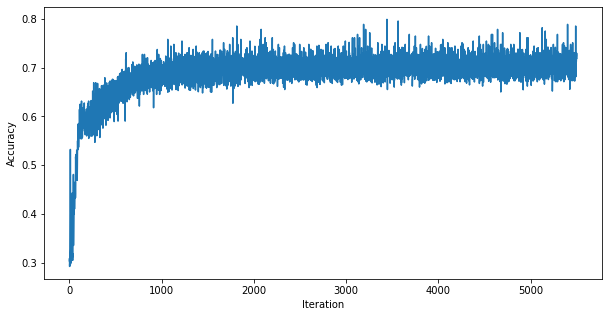

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

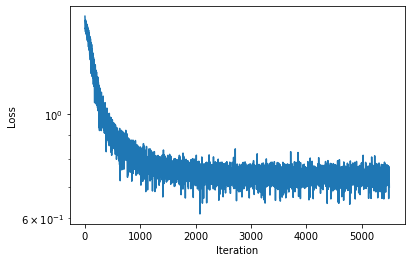

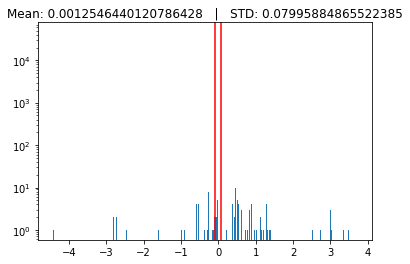

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.0344827586206895


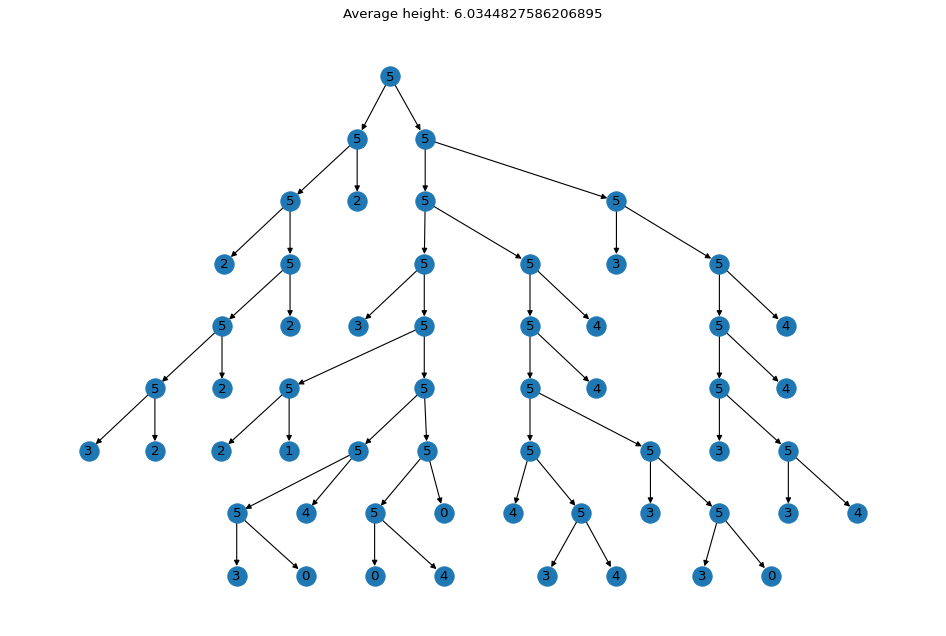

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 29


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()